In [17]:
import random
import copy
import networkx as nx
import matplotlib.pyplot as plt

### Реалізація класу "Граф"

In [18]:
class Graph:
    """
    Базовий абстрактний клас Граф.
    За замовчуванням використовує списки суміжності ('list').
    """
    def __init__(self, n, weighted=False):
        self.n = n
        self.weighted = weighted
        self.vertices = set(range(1, n + 1))
        self.representation = 'list'  # 'list' або 'matrix'
        
        # Структура для списків: {u: {v: weight, ...}, ...}
        self.adj_list = {v: {} for v in self.vertices}
        
        # Структура для матриці (буде ініціалізована при конвертації)
        self.adj_matrix = None 

    def _validate_vertex(self, v):
        if v not in self.vertices:
            raise ValueError(f"Вершина {v} не існує в графі.")

    def set_representation(self, mode):
        """Змінює внутрішнє представлення графу (Завдання 4)"""
        if mode == self.representation:
            return

        if mode == 'matrix':
            # Конвертація List -> Matrix
            self.adj_matrix = [[0] * (max(self.vertices, default=0) + 1) 
                               for _ in range(max(self.vertices, default=0) + 1)]
            for u, neighbors in self.adj_list.items():
                for v, w in neighbors.items():
                    self.adj_matrix[u][v] = w
            self.adj_list = None
            self.representation = 'matrix'
            print("-> Конвертовано у Матрицю суміжності")
            
        elif mode == 'list':
            # Конвертація Matrix -> List
            max_id = len(self.adj_matrix) - 1
            self.adj_list = {v: {} for v in self.vertices}
            for i in range(1, max_id + 1):
                if i in self.vertices:
                    for j in range(1, max_id + 1):
                        if self.adj_matrix[i][j] != 0:
                            self.adj_list[i][j] = self.adj_matrix[i][j]
            self.adj_matrix = None
            self.representation = 'list'
            print("-> Конвертовано у Списки суміжності")

    # --- Базові операції (Завдання 3) ---

    def add_vertex(self):
        """Додає нову вершину з наступним порядковим номером."""
        new_v = max(self.vertices, default=0) + 1
        self.vertices.add(new_v)
        self.n += 1
        
        if self.representation == 'list':
            self.adj_list[new_v] = {}
        elif self.representation == 'matrix':
            # Розширюємо матрицю
            for row in self.adj_matrix:
                row.append(0)
            self.adj_matrix.append([0] * (new_v + 1))
            
        print(f"Додано вершину {new_v}")
        return new_v

    def remove_vertex(self, v):
        self._validate_vertex(v)
        self.vertices.remove(v)
        self.n -= 1
        
        if self.representation == 'list':
            # Видаляємо саму вершину
            del self.adj_list[v]
            # Видаляємо всі ребра, що ведуть до неї
            for u in self.adj_list:
                if v in self.adj_list[u]:
                    del self.adj_list[u][v]
                    
        elif self.representation == 'matrix':
            # У матриці просто зануляємо відповідні рядки/стовпці 
            # (або можна видаляти фізично, але це змінить індексацію)
            # Для збереження ID просто очистимо зв'язки
            for i in range(len(self.adj_matrix)):
                self.adj_matrix[i][v] = 0
                self.adj_matrix[v][i] = 0

        print(f"Видалено вершину {v}")

    def add_edge(self, u, v, weight=1):
        self._validate_vertex(u)
        self._validate_vertex(v)
        if not self.weighted:
            weight = 1
            
        if self.representation == 'list':
            self.adj_list[u][v] = weight
            if isinstance(self, UndirectedGraph):
                self.adj_list[v][u] = weight
                
        elif self.representation == 'matrix':
            self.adj_matrix[u][v] = weight
            if isinstance(self, UndirectedGraph):
                self.adj_matrix[v][u] = weight
        
        w_str = f" (вага {weight})" if self.weighted else ""
        print(f"Додано ребро {u}-{v}{w_str}")

    def remove_edge(self, u, v):
        self._validate_vertex(u)
        self._validate_vertex(v)
        
        if self.representation == 'list':
            if v in self.adj_list[u]:
                del self.adj_list[u][v]
            if isinstance(self, UndirectedGraph):
                if u in self.adj_list[v]:
                    del self.adj_list[v][u]
                    
        elif self.representation == 'matrix':
            self.adj_matrix[u][v] = 0
            if isinstance(self, UndirectedGraph):
                self.adj_matrix[v][u] = 0
                
        print(f"Видалено ребро {u}-{v}")

    def print_graph(self):
        print(f"\n--- Граф ({self.__class__.__name__}, {self.representation}) ---")
        if self.representation == 'list':
            for v in sorted(self.vertices):
                print(f"{v}: {self.adj_list[v]}")
        elif self.representation == 'matrix':
            print("   ", end="")
            nodes = sorted(list(self.vertices))
            for v in nodes: print(f"{v:3}", end="")
            print()
            for u in nodes:
                print(f"{u:2}|", end="")
                for v in nodes:
                    print(f"{self.adj_matrix[u][v]:3}", end="")
                print()
        print("-" * 20)

    # --- Генерація (Завдання 5) ---
    @staticmethod
    def generate_erdos_renyi(n, p, directed=False, weighted=False, weight_range=(1, 10)):
        if directed:
            g = DirectedGraph(n, weighted)
        else:
            g = UndirectedGraph(n, weighted)
            
        print(f"\nГенерація графа Ердеша-Реньї (n={n}, p={p})...")
        nodes = list(g.vertices)
        
        # Перебираємо всі можливі пари
        if directed:
            pairs = [(u, v) for u in nodes for v in nodes if u != v]
        else:
            pairs = []
            for i in range(len(nodes)):
                for j in range(i + 1, len(nodes)):
                    pairs.append((nodes[i], nodes[j]))
        
        count = 0
        for u, v in pairs:
            if random.random() <= p:
                w = random.randint(*weight_range) if weighted else 1
                g.add_edge(u, v, w)
                count += 1
        
        # Щоб не спамити консоль при генерації, вивід add_edge можна закоментувати вище
        print(f"Згенеровано {count} ребер.")
        return g

    # --- Візуалізація (Бонус) ---
    def visualize(self):
        print("\nВізуалізація графа...")
        G_nx = nx.DiGraph() if isinstance(self, DirectedGraph) else nx.Graph()
        
        # Тимчасово конвертуємо в список для зручності читання, якщо ми в матриці
        temp_list = self.adj_list
        if self.representation == 'matrix':
            # Простий зчитувач з матриці
            temp_list = {u: {} for u in self.vertices}
            for u in self.vertices:
                for v in self.vertices:
                    if self.adj_matrix[u][v] != 0:
                        temp_list[u][v] = self.adj_matrix[u][v]

        for u, neighbors in temp_list.items():
            G_nx.add_node(u)
            for v, w in neighbors.items():
                G_nx.add_edge(u, v, weight=w)

        pos = nx.spring_layout(G_nx)
        plt.figure(figsize=(8, 6))
        
        nx.draw_networkx_nodes(G_nx, pos, node_color='lightblue', node_size=500)
        nx.draw_networkx_labels(G_nx, pos)
        
        if self.weighted:
            edge_labels = nx.get_edge_attributes(G_nx, 'weight')
            nx.draw_networkx_edge_labels(G_nx, pos, edge_labels=edge_labels)
            nx.draw_networkx_edges(G_nx, pos, edge_color='gray')
        else:
            nx.draw_networkx_edges(G_nx, pos, edge_color='black')

        plt.title(f"{self.__class__.__name__} Visualization")
        plt.axis('off')
        plt.show()


### Класи-нащадки

In [19]:
class UndirectedGraph(Graph):
    def __init__(self, n, weighted=False):
        super().__init__(n, weighted)

class DirectedGraph(Graph):
    def __init__(self, n, weighted=False):
        super().__init__(n, weighted)

### Демонстрація роботи

Додано ребро 1-2
Додано ребро 2-3

--- Граф (UndirectedGraph, list) ---
1: {2: 1}
2: {1: 1, 3: 1}
3: {2: 1}
--------------------
Додано вершину 4
Додано ребро 1-4

--- Граф (UndirectedGraph, list) ---
1: {2: 1, 4: 1}
2: {1: 1, 3: 1}
3: {2: 1}
4: {1: 1}
--------------------
-> Конвертовано у Матрицю суміжності

--- Граф (UndirectedGraph, matrix) ---
     1  2  3  4
 1|  0  1  0  1
 2|  1  0  1  0
 3|  0  1  0  0
 4|  1  0  0  0
--------------------
Додано ребро 3-4

--- Граф (UndirectedGraph, matrix) ---
     1  2  3  4
 1|  0  1  0  1
 2|  1  0  1  0
 3|  0  1  0  1
 4|  1  0  1  0
--------------------
-> Конвертовано у Списки суміжності
Видалено ребро 1-2
Видалено вершину 3

--- Граф (UndirectedGraph, list) ---
1: {4: 1}
2: {}
4: {1: 1}
--------------------

--- Тест генератора Ердеша-Реньї ---

Генерація графа Ердеша-Реньї (n=5, p=0.4)...
Додано ребро 1-3 (вага 9)
Додано ребро 1-4 (вага 1)
Додано ребро 1-5 (вага 8)
Додано ребро 2-1 (вага 4)
Додано ребро 2-3 (вага 5)
Додано ребро 3-5 

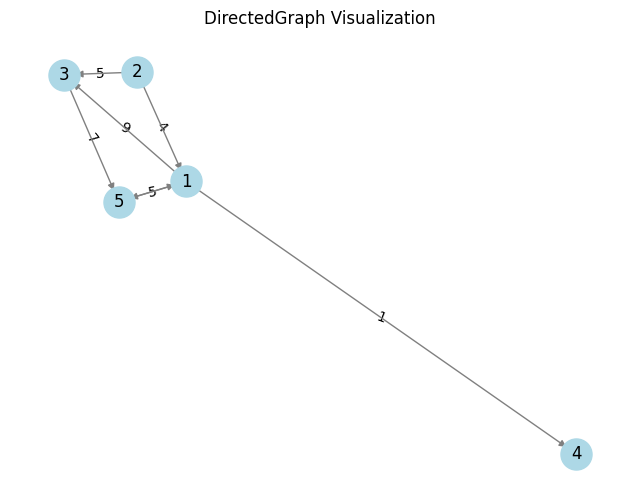

In [ ]:

# 1. Створення неорієнтованого графа
g = UndirectedGraph(3)
g.add_edge(1, 2)
g.add_edge(2, 3)
g.print_graph()

# 2. Додавання вершини та ребра
v4 = g.add_vertex()
g.add_edge(1, v4)
g.print_graph()

# 3. Конвертація в матрицю суміжності
g.set_representation('matrix')
g.print_graph()

# Додамо ребро в режимі матриці
g.add_edge(3, v4)
g.print_graph()

# Конвертація назад
g.set_representation('list')

# 4. Видалення
g.remove_edge(1, 2)
g.remove_vertex(3)
g.print_graph()

# 5. Генерація випадкового зваженого орієнтованого графа
print("\n--- Тест генератора Ердеша-Реньї ---")
random_g = Graph.generate_erdos_renyi(n=5, p=0.4, directed=True, weighted=True, weight_range=(1, 9))
random_g.print_graph()

# 6. Візуалізація
random_g.visualize()